# The Ambulance Routing Problem

## Description

One potential application of reinforcement learning involves positioning a server or servers (in this case an ambulance) in an optimal way geographically to respond to incoming calls while minimizing the distance traveled by the servers. This is closely related to the [k-server problem](https://en.wikipedia.org/wiki/K-server_problem), where there are $k$ servers stationed in a space that must respond to requests arriving in that space in such a way as to minimize the total distance traveled. 

The ambulance routing problem addresses the problem by modeling an environment where there are ambulances stationed at locations, and calls come in that one of the ambulances must be sent to respond to. The goal of the agent is to minimize both the distance traveled by the ambulances between calls and the distance traveled to respond to a call by optimally choosing the locations to station the ambulances. The ambulance environment has been implemented in two different ways; as a 1-dimensional number line $[0,1]$ along which ambulances will be stationed and calls will arrive, and a graph with nodes where ambulances can be stationed and calls can arrive, and edges between the nodes that ambulances travel along.

See [here](https://ojs.aaai.org/index.php/ICAPS/article/view/3528) for another simulator for facility location models.


### Line

`ambulance_metric.py` is a 1-dimensional reinforcement learning environment in the space $X = [0, 1]$. Each ambulance in the problem can be located anywhere in $X$, so the state space is $S = X^k$, where $k$ is the number of ambulances. The distance function is chosen by the user, who specifies what kind of norm to use. Calls for an ambulance can also arrive anywhere in $X$, and the nearest ambulance will respond to the call, leaving the locations of the other ambulances unchanged. Between calls the agent must choose a location to station each ambulance, with the goal of minimizing both the distance traveled between calls and to respond to a call.

The default distribution for call arrivals is $Beta(5, 2)$ over $[0,1]$, however any probability distribution defined over the interval $[0,1]$ is valid. The probability distribution can also change with each timestep.

For example, in a problem with two ambulances, imagine the ambulances are initially located at $0.4$ and $0.6$, and the distance function being used is the $\ell_1$ norm. The agent could choose to move the ambulances to $0.342$ and $0.887$. If a call arrived at $0.115$, ambulance 1, which was at $0.342$, would respond to that call, and the state at the end of the iteration would be ambulance 1 at $0.115$ and ambulance 2 at $0.887$. The agent could then choose new locations to move the ambulances to, and the cycle would repeat.

At the beginning of the iteration:

<div>
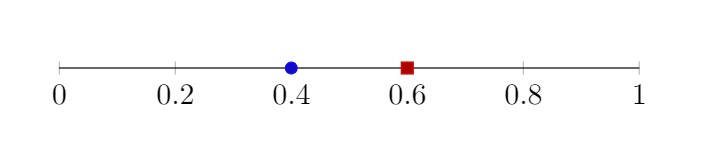
</div>

After the ambulances move to the locations specified by the agent:

<div>
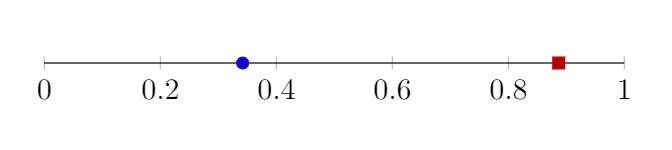
</div>

After ambulance 1 responds to the call:

<div>
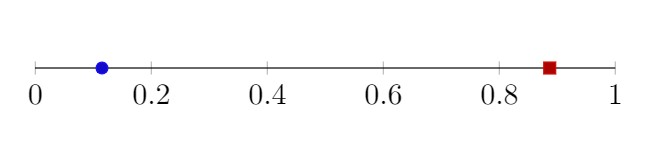
</div>


### Graph 

`ambulance_graph.py` is structured as a graph of nodes $V$ with edges between the nodes $E$. Each node represents a location where an ambulance could be stationed or a call could come in. The edges between nodes are undirected and have a weight representing the distance between those two nodes.

The nearest ambulance to a call is determined by computing the shortest path from each ambulance to the call, and choosing the ambulance with the minimum length path. The calls arrive using a prespecified iid probability distribution. The default is for the probability of call arrivals to be evenly distributed over all the nodes; however, the user can also choose different probabilities for each of the nodes that a call will arrive at that node. For example, in the following graph the default setting would be for each call to have a 0.25 probability of arriving at each node, but the user could instead specify that there is a 0.1 probability of a call at node 0, and a 0.3 probability of a call arriving at each of the other three nodes.

<div>
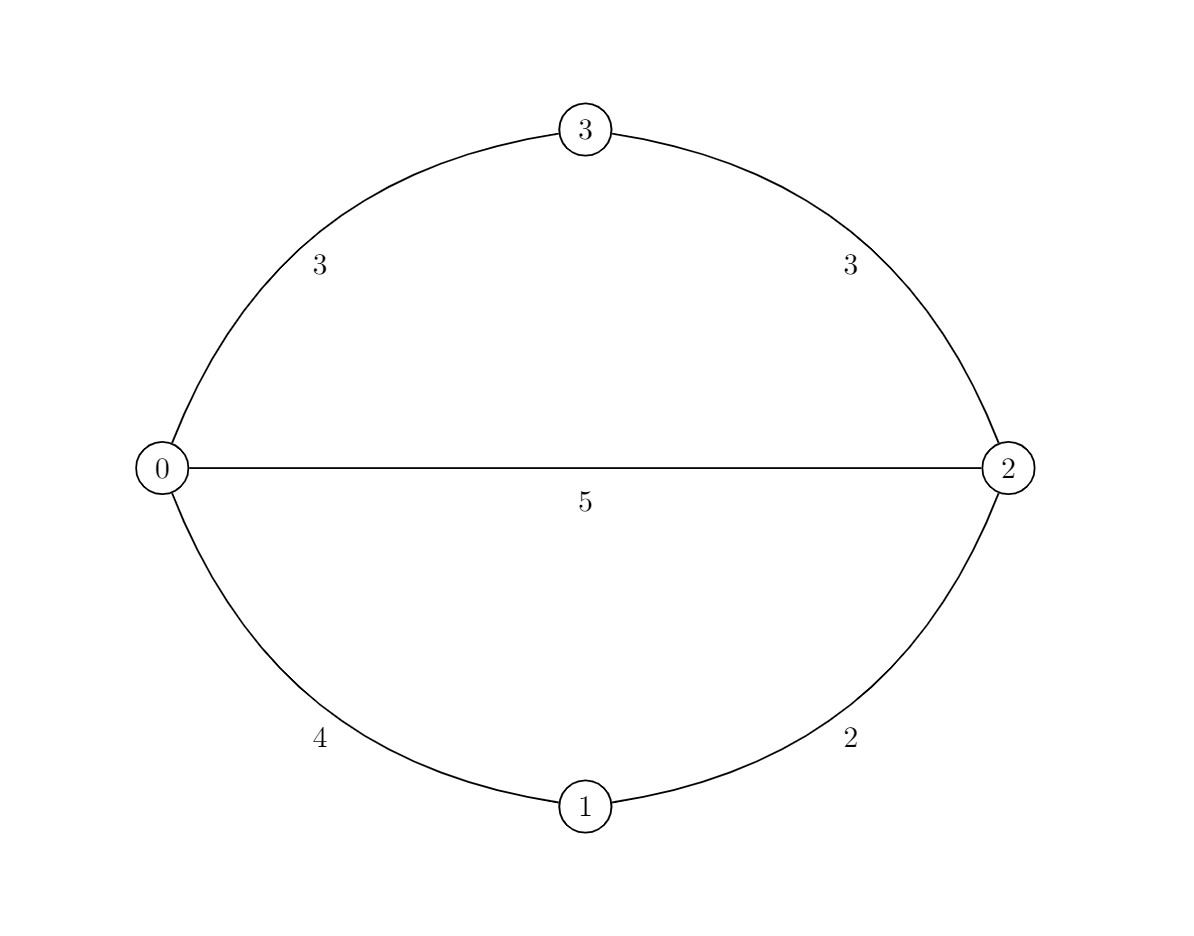
</div>

After each call comes in, the agent will choose where to move each ambulance in the graph. Every ambulance except the ambulance that moved to respond to the call will be at the same location where the agent moved it to on the previous iteration, and the ambulance that moved to respond to the call will be at the node where the call came in. 

The graph environment is currently implemented using the [networkx package](https://networkx.org/documentation/stable/index.html).


## Model Assumptions 

* New calls do not arrive while an ambulance is in transit

* There is no step for traveling to a hospital after responding to a call

## Dynamics

### State Space

#### Line

The state space for the line environment is $S = X^k$ where $X = [0, 1]$ and there are $k$ ambulances. Each ambulance can be located at any point on the line $X$. 

#### Graph

The graph environment consists of nodes $V$ and edges between the nodes $E$, and each ambulance can be located at any node $v \in V$ (and multiple ambulances can be at the same node). The state space of this environment is $S = V^k$, where $k$ is the number of ambulances.


### Action space

#### Line

The agent chooses a location for each ambulance to travel to between calls. The location for each ambulance can be any point $t \in X$ where $X = [0, 1]$.

#### Graph

The agent chooses a node for each ambulance to travel to between calls. The location for any ambulance can be any node $v \in V$, so the action space $A$ will be $A = V^k$.


### Reward

The reward is $-1 \cdot (\alpha \cdot d(s, a) + (1 - \alpha) \cdot d(a, n))$ where $s$ is the previous state of the system, $a$ is the action chosen by the user, $n$ is the state of the system after the new call arrival, and $d$ is the distance function. In the case of the metric environment $d$ is the norm specified by the user, and in the graph environment $d$ is the shortest distance between two nodes. The goal of the agent is to maximize this reward, and because the reward is negative this implies getting the reward as close to $0$ as possible.

The $\alpha$ parameter allows the user to control the proportional difference in cost to move ambulances normally versus when responding to an emergency. In real world scenarios the distance traveled to respond to a call will likely be more costly than the distance traveled between calls because of the additional cost of someone having to wait a long time for an ambulance.

By collecting data on their past actions, call arrival locations, and associated rewards, an agent's goal is to learn how to most effectively position ambulances to respond to calls to minimize the distance the ambulances have to travel.


### Transitions

Given an initial state at the start of the iteration $x$, an action chosen by the user $a$, and a call arrival $p$, the state at the end of the iteration will be 

$\begin{align*}
    x_i^{new} & = \begin{cases}
        a_i \qquad & i \neq i^\star \\
        p_h \qquad & i = i^\star
        \end{cases} \\
\end{align*}$ 

for all ambulances $i \in [k]$, where $i^*$ is the nearest ambulance to the call $p$ from the action $a$

$\begin{align*}
    i^\star = \text{argmin}_{i \in [k]} |a_i - p|
\end{align*}$

## Environment

### Metric

`reset`

Returns the environment to its original state.

`step(action)`

Takes an action from the agent and returns the state of the system after the next arrival.
* `action`: a list with the location of each ambulance, where each location is a float between $0$ and $1$.

Ex. two ambulances at 0.572 and 0.473 would be `[0.572, 0.473]`

Returns:

* `state`: A list containing the locations of each ambulance

* `reward`: The reward associated with the most recent action and event

* `pContinue`:

* `info`: a dictionary containing the node where the most recent arrival occured
  - Ex. `{'arrival': 0.988}` if the most recent arrival was at 0.988

`render`

Renders an iteration by showing three pictures: where the ambulances are after moving to their action location, the location of the call arrival, and the locations of the ambulances after an ambulance moves to respond to the call.

Takes one parameter `mode`. When `mode = "rgb_array"` returns a tuple of three rgb_arrays representing the three different images that need to be rendered.

`close`

Currently unimplemented


Init parameters for the line ambulance environment, passed in using a dictionary named CONFIG

* `epLen`: the length of each episode, i.e. how many calls will come in before the episode terminates.

* `arrival_dist(timestep)`: a function that returns a sample from a probability distribution. The probability distribution can change with each timestep.

* `alpha`: a float $\in [0,1]$ that controls the proportional difference between the cost to move ambulances in between calls and the cost to move an ambulance to respond to a call.
  - `alpha = 0`: no cost to move between calls
  - `alpha = 1`: no cost to move to respond to a call

* `starting_state`: a list of floats $\in (0,1)$ the length of the number of ambulances. Each entry in the list corresponds to the starting location for that ambulance.

* `num_ambulance`: integer representing the number of ambulances in the system

* `norm`: an integer representing the norm to use to calculate distances; in most cases it should probably be set to 1 to be the $\ell_1$ norm



### Graph

`reset`

Returns the environment to its original state.

`step(action)`

Takes an action from the agent and returns the state of the system after the next arrival.
* `action`: a list with the location of each ambulance

Ex. two ambulances at nodes 0 and 6 would be `[0, 6]`

Returns:

* `state`: A list containing the locations of each ambulance

* `reward`: The reward associated with the most recent action and event

* `pContinue`:

* `info`: a dictionary containing the node where the most recent arrival occured
  - Ex. `{'arrival': 1}` if the most recent arrival was at node 1

`render`

Currently unimplemented

`close`

Currently unimplemented

Init parameters for the graph ambulance environment, passed in using a dictionary named CONFIG

* `epLen`: the length of each episode, i.e. how many calls will come in before the episode terminates.

* `arrival_dist(timestep, num_nodes, [arrival_data])`: a function on the timestep and number of nodes in the graph (and a list of arrival data if `from_data = True`), returning a numpy array with an entry for each node in the graph representing the probability of an arrival occurring at that node. All the entries in the array must forma a probability distribution, i.e. they must sum to 1.
    - When generating arrivals from data, the arrivals might be deterministic. In this case the array generated at each timestep would have an entry of 1 at the node where the call arrives and 0 for all other nodes.

* `alpha`: controls the proportional difference between the cost to move ambulances in between calls and the cost to move an ambulance to respond to a call.
  - `alpha = 0`: no cost to move between calls
  - `alpha = 1`: no cost to move to respond to a call

* `from_data`: an indicator of whether or not the ambulance arrivals are being read from data

* `edges`: a list of tuples where each tuple has three entries corresponding to the starting node, the ending node, and the distance between them. The distance is a dictionary with one entry, 'travel_time', where the value is an int representing the time required to travel between the two nodes
  - Ex. `(0, 4, {'travel_time': 2})` is an edge between nodes 0 and 4 with travel time 2
  - The graph is undirected and nodes are inferred from the edges
  - Requires that the graph is fully connected
  - Requires that the numbering of nodes is chronological and starts at 0 (ie, if you have 5 nodes they must be labeled 0, 1, 2, 3, and 4)

* `starting_state`: a list where each index corresponds to an ambulance, and the entry at that index is the node where the ambulance is located

* `num_ambulance`: integer representing the number of ambulances in the system (kind of redundant, maybe we should get rid of this?)


## Heuristic Agents

### Stable Agent

The stable agent does not move any of the ambulances between calls, and the only time an ambulance moves is when responding to an incoming call. In other words, the policy $\pi$ chosen by the agent for any given state $X$ will be $\pi_h(X) = X$

### Metric Median Agent

The median agent for the metric environment takes a list of all past call arrivals sorted by arrival location, and partitions it into $k$ quantiles where $k$ is the number of ambulances. The algorithm then selects the middle data point in each quantile as the locations to station the ambulances.

### Metric K-Mediod Agent

**k-medoid is currently not included because it takes too long to run**

The k-medoid agent uses the k-medoid algorithm where $k$ is the number of ambulances to figure out where to station ambulances. The k-medoids algorithm attempts to find $k$ clusters of data such that the total distance from each of the data points to the center of the cluster is minimized, however it differs from k-means in that it always chooses an element of the dataset as the center of the cluster. The k-medoid agent is implemented using the [scikit learn k-medoids algorithm](https://scikit-learn-extra.readthedocs.io/en/latest/generated/sklearn_extra.cluster.KMedoids.html). The policy $\pi$ chosen by the agent for a state $X$ will be $\pi_h(X) = kmedoid\text{(historical call data)}$

The precise definition of the medoid $x_{\text{medoid}}$ for a set of points $\mathcal{X} := \{x_1, x_2, ..., x_n\}$ with a distance function $d$ is

$x_{\text{medoid}} = \text{arg} \text{min}_{y \in \mathcal{X}} \sum_{i=1}^n d(y, x_i)$

### Graph Median Agent

The median agent for the graph environment chooses to station the ambulances at the nodes where the minimum distance would have to be traveled to respond to all calls that have arrived in the past. The distance between each pair of nodes is calculated and put into a (symmetric) matrix, where an entry in the matrix $(i, j)$ is the length of the shortest path between nodes $i$ and $j$. This matrix is multiplied by a vector containing the number of calls that have arrived at each node in the past. The minimum total distances in the resulting matrix are chosen as the nodes at which to station the ambulances.

The following is an example calculated for the graph from the overview assuming the data of past call arrivals is:

$[0,0,3,2,0,1,1,1,0,3,3,3,2,3,3]$

<div>
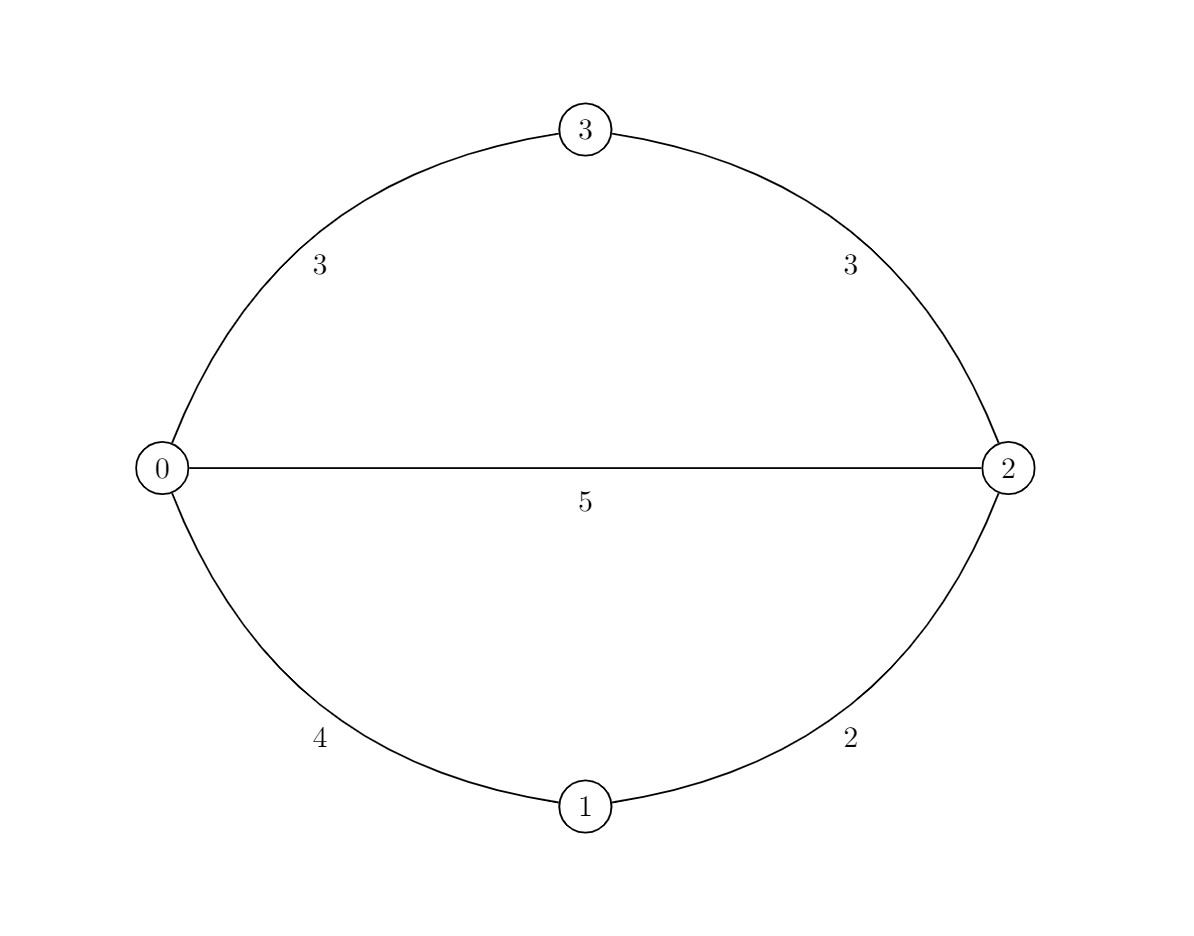
</div>

$\begin{bmatrix}
d(0,0) & d(0,1) & d(0,2) & d(0,3)\\
d(1,0) & d(1,1) & d(1,2) & d(1,3)\\
d(2,0) & d(2,1) & d(2,2) & d(2,3)\\
d(3,0) & d(3,1) & d(3,2) & d(3,3)
\end{bmatrix} = 
\begin{bmatrix}
0 & 4 & 5 & 3\\
4 & 0 & 2 & 5\\
5 & 2 & 0 & 3\\
3 & 5 & 3 & 0
\end{bmatrix}$


$\begin{bmatrix}
\sum_{x \in \text{past data}} \mathbb{1}(x = 0)\\
\sum_{x \in \text{past data}} \mathbb{1}(x = 1)\\
\sum_{x \in \text{past data}} \mathbb{1}(x = 2)\\
\sum_{x \in \text{past data}} \mathbb{1}(x = 3)
\end{bmatrix} = 
\begin{bmatrix}
4\\
3\\
2\\
6
\end{bmatrix}$


$\begin{bmatrix}
0 & 4 & 5 & 3\\
4 & 0 & 2 & 5\\
5 & 2 & 0 & 3\\
3 & 5 & 3 & 0
\end{bmatrix}
\begin{bmatrix}
4\\
3\\
2\\
6
\end{bmatrix}
 = \begin{bmatrix}
40\\
50\\
44\\
33
\end{bmatrix}$

The graph median agent would choose to position the first ambulance at node 3, the second ambulance at node 0, etc.


### Graph Mode Agent

The mode agent chooses to station the ambulances at the nodes where the most calls have come in the past. The first ambulance will be stationed at the node with the most historical calls, the second ambulance at the node with the second most historical calls, etc. The policy $\pi$ chosen by the agent for a state $X$ will be $\pi_h(X) = mode\text{(historical call data)}$
